Link to paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7948653/
Link to GitHub: https://github.com/NourozR/Stock-Price-Prediction-LSTM/blob/master/StockPricePrediction.py

**LOAD IN preprocessing.py and INDEX.csv INTO RUNTIME FOR CODE TO RUN**

In [1]:
# IMPORTING IMPORTANT LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
import preprocessing 
import yahoodata as yd # File added as a function to parse our index data

In [2]:
# IMPORTING DATASET
# This whole cell is brand new, utilizing pullStockData function from yahoodata
# XLI: Industrial Select Sector SPDR Fund

dataset = yd.pullStockData("XLI", 2016, 3, 31, 2021, 11, 17)

dataset


,High,Low,Open,Close
Date,,,,
2016-03-31,55.790001,55.400002,55.709999,55.470001
2016-04-01,55.730000,54.750000,55.150002,55.730000
2016-04-04,55.610001,55.000000,55.540001,55.099998
2016-04-05,55.009998,54.560001,54.730000,54.759998
2016-04-06,55.029999,54.250000,54.740002,55.029999
...,...,...,...,...
2021-11-11,106.709999,105.949997,106.709999,106.059998
2021-11-12,107.080002,106.019997,106.360001,106.900002
2021-11-15,107.449997,106.860001,107.330002,107.099998


In [3]:
# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)

In [4]:
# TAKING DIFFERENT INDICATORS FOR PREDICTION
OHLC_avg = dataset.mean(axis = 1)
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]

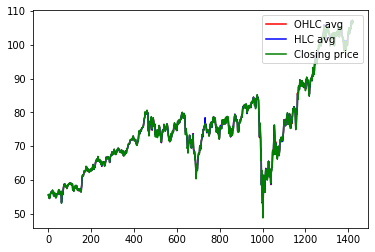

In [5]:
# PLOTTING ALL INDICATORS IN ONE PLOT
plt.plot(obs, OHLC_avg, 'r', label = 'OHLC avg')
plt.plot(obs, HLC_avg, 'b', label = 'HLC avg')
plt.plot(obs, close_val, 'g', label = 'Closing price')
plt.legend(loc = 'upper right')
plt.show()


In [6]:
# PREPARATION OF TIME SERIES DATASET
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1))
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)

In [7]:
# TRAIN-TEST SPLIT
train_OHLC = int(len(OHLC_avg) * 0.7) # Changed to a 30/70 split from original dataset
train_OHLC_placeholder = train_OHLC
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

In [8]:
# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
trainX, trainY = preprocessing.new_dataset(train_OHLC, 1)
testX, testY = preprocessing.new_dataset(test_OHLC, 1)

In [9]:
# RESHAPING TRAIN AND TEST DATA
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1

In [10]:
# LSTM MODEL
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

2021-11-30 22:55:11.327617: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
# MODEL COMPILING AND TRAINING
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mse','mae']) # Switched from SGD to adam
history = model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2) # Changed from 5 to 50 epochs

Epoch 1/50
992/992 - 6s - loss: 0.0099 - mse: 0.0099 - mae: 0.0568 - 6s/epoch - 6ms/step
Epoch 2/50
992/992 - 4s - loss: 2.6800e-04 - mse: 2.6800e-04 - mae: 0.0128 - 4s/epoch - 4ms/step
Epoch 3/50
992/992 - 4s - loss: 2.3242e-04 - mse: 2.3242e-04 - mae: 0.0118 - 4s/epoch - 4ms/step
Epoch 4/50
992/992 - 3s - loss: 1.9672e-04 - mse: 1.9672e-04 - mae: 0.0107 - 3s/epoch - 3ms/step
Epoch 5/50
992/992 - 3s - loss: 1.6421e-04 - mse: 1.6421e-04 - mae: 0.0095 - 3s/epoch - 3ms/step
Epoch 6/50
992/992 - 3s - loss: 1.7207e-04 - mse: 1.7207e-04 - mae: 0.0097 - 3s/epoch - 3ms/step
Epoch 7/50
992/992 - 3s - loss: 1.6571e-04 - mse: 1.6571e-04 - mae: 0.0094 - 3s/epoch - 3ms/step
Epoch 8/50
992/992 - 3s - loss: 1.5712e-04 - mse: 1.5712e-04 - mae: 0.0093 - 3s/epoch - 3ms/step
Epoch 9/50
992/992 - 4s - loss: 1.6141e-04 - mse: 1.6141e-04 - mae: 0.0094 - 4s/epoch - 4ms/step
Epoch 10/50
992/992 - 4s - loss: 1.5677e-04 - mse: 1.5677e-04 - mae: 0.0092 - 4s/epoch - 4ms/step
Epoch 11/50
992/992 - 4s - loss: 1.68

In [12]:
# PREDICTION
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


In [13]:
# DE-NORMALIZING FOR PLOTTING
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [14]:
# TRAINING RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))

Train RMSE: 0.67


In [15]:
# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))


Test RMSE: 2.88


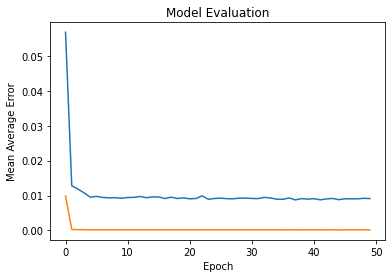

In [16]:
# GRAPHING EVALUATION METRICS

plt.plot(history.history['mae'])
plt.plot(history.history['mse'])

plt.title('Model Evaluation')
plt.ylabel("Mean Average Error")
plt.xlabel("Epoch")
plt.show()

In [17]:
# RESULTS FOR MAE AND MSE
results = model.evaluate(testPredict, np.concatenate(testY), batch_size = 1)


425/425 [==============================] - 2s 2ms/step - loss: 7515.3208 - mse: 7515.3208 - mae: 85.3344


In [18]:
# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

In [19]:
# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict

In [20]:
# DE-NORMALIZING MAIN DATASET 
OHLC_avg = scaler.inverse_transform(OHLC_avg)

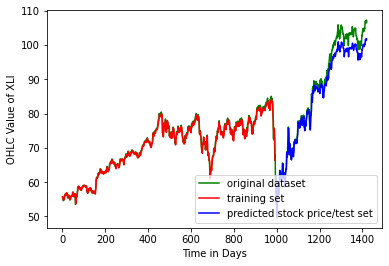

In [25]:
# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.plot(OHLC_avg, 'g', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'lower right')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of XLI')
plt.savefig("images/XLI.png", dpi=1000)  #Added this line to save a picture of the plot itself
plt.show()


In [22]:
# PREDICT FUTURE VALUES (Valuation)
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))


In [23]:
# PRINT LAST VALUE

"Last Day Value:", last_val.item()

('Last Day Value:', 101.80022430419922)

In [24]:
# PRINT NEXT DAY PREDICTED VALUE

"Next Day Value:", (last_val*next_val).item()

('Next Day Value:', 92.27513885498047)